In [14]:
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import lightkurve as lk
import threemultis

In [28]:
tpf = lk.search_targetpixelfile('K2-168').download()
tpf = tpf[10:]
tpf = tpf[np.in1d(tpf.time, tpf.to_lightcurve(aperture_mask='all').remove_nans().time)]
tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]


mask = threemultis.utils.planet_mask(tpf.time, 'K2-168')

In [29]:
aper = np.nanmedian(tpf.flux, axis=0) > 30

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [30]:
# First pass, remove some very bad outliers
bad = np.zeros(len(tpf.time), bool)
for count in range(2):
    pld_lc = tpf[~bad].to_corrector('pld').correct(aperture_mask=aper, cadence_mask=mask[~bad])
    pld_lc = pld_lc.flatten(31, mask=~mask[~bad])
    bad |= np.in1d(tpf.time, pld_lc.time[np.abs(pld_lc.flux - 1) > 5 * np.std(pld_lc.flux - 1)])
    
tpf = tpf[~bad]
mask = mask[~bad]

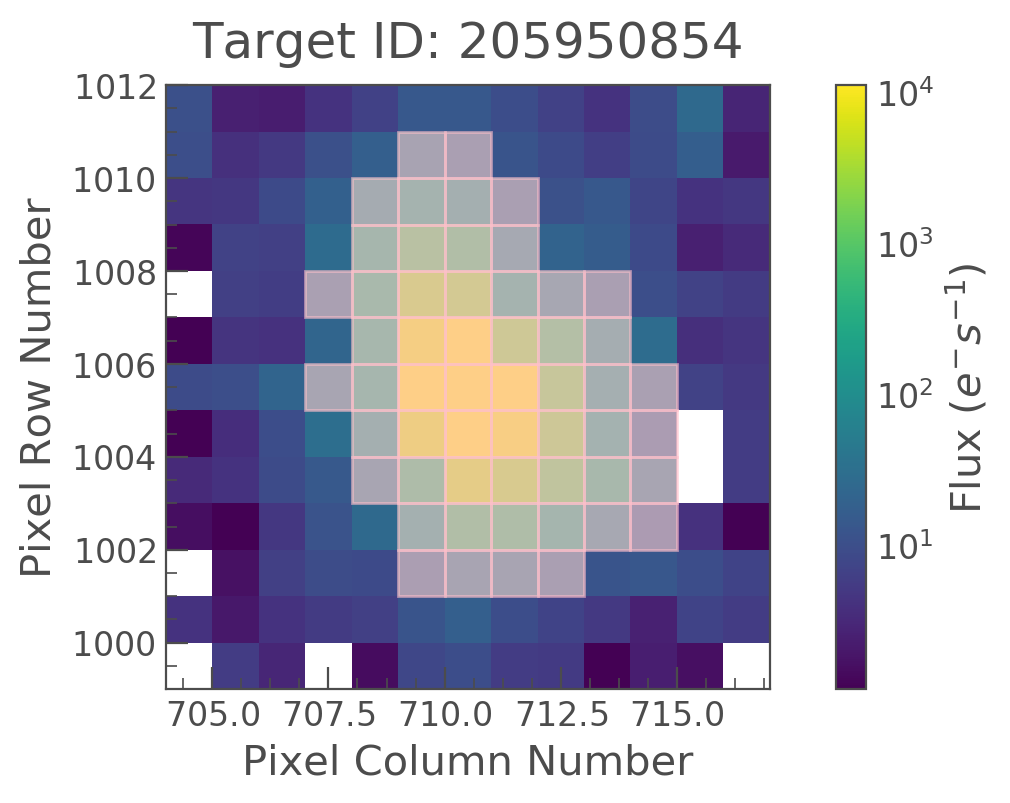

In [31]:
tpf.plot(scale='log', aperture_mask=aper)

In [32]:
params = threemultis.utils.get_params('K2-168')

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


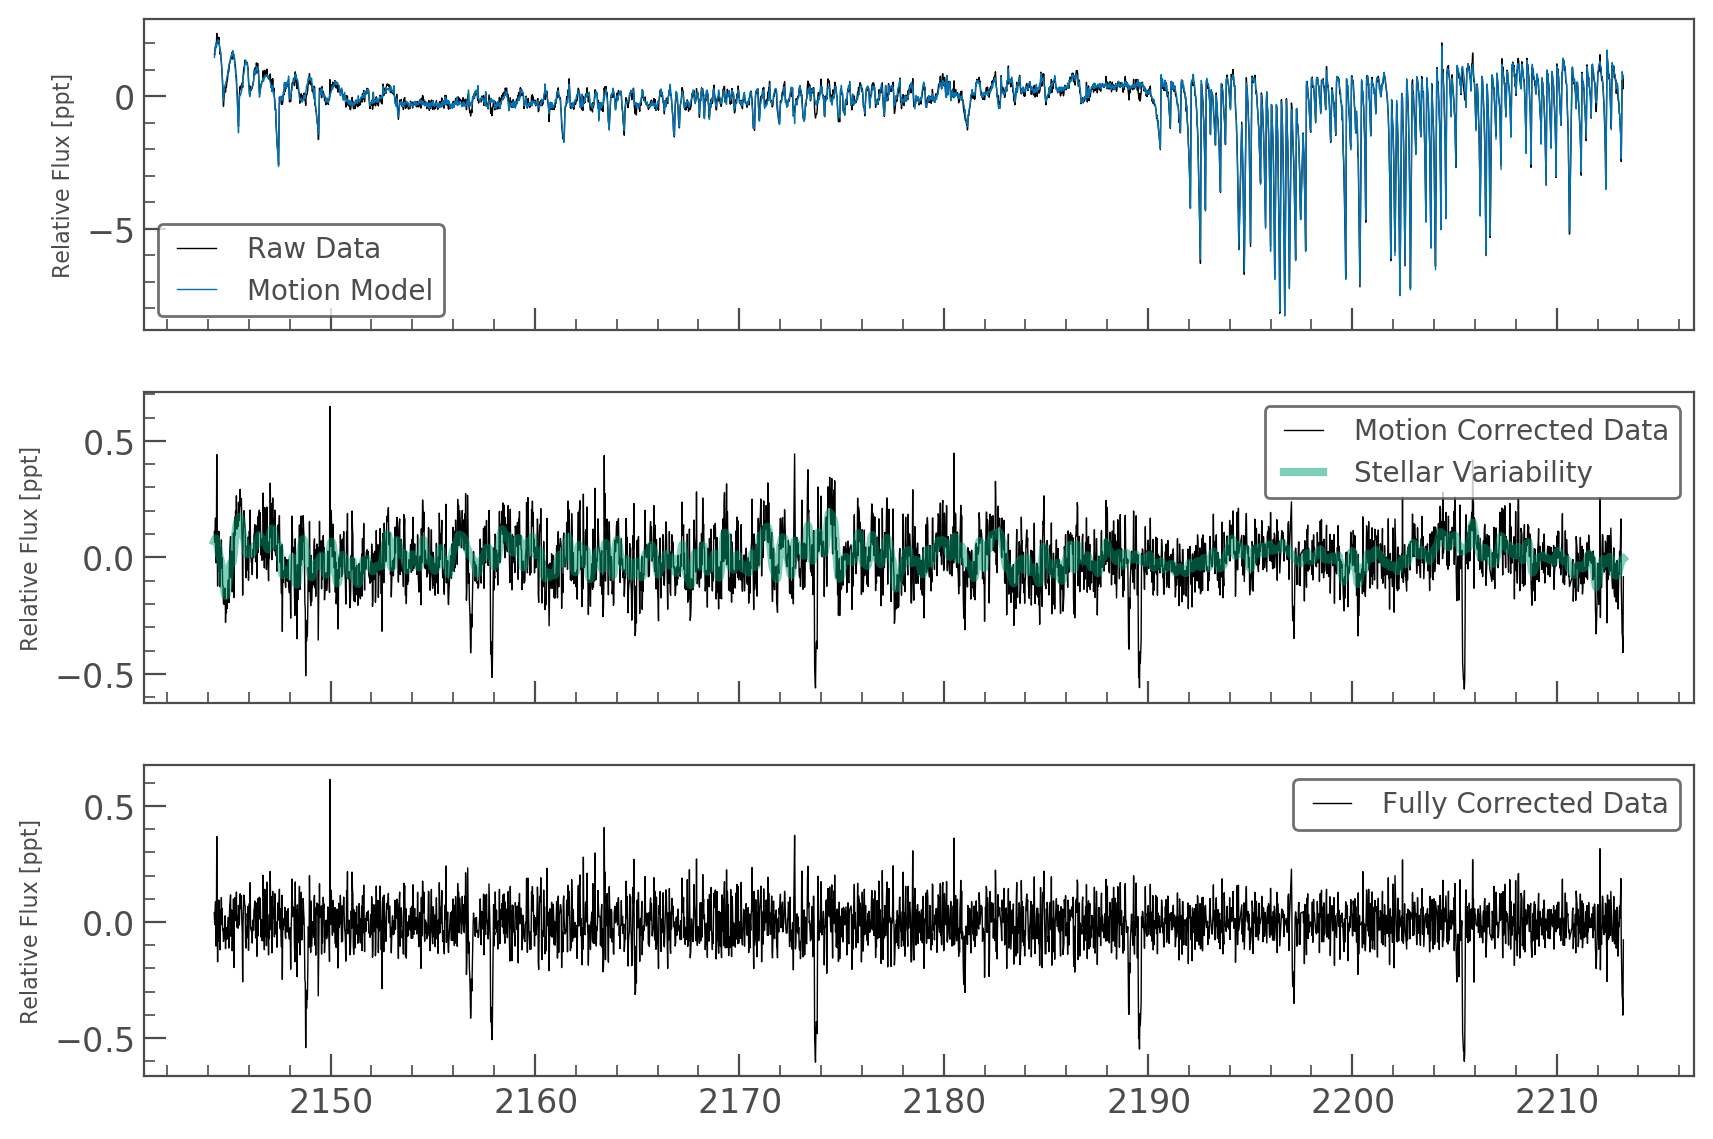

In [41]:
clc = threemultis.fit.PLD(tpf, planet_mask=mask, trim=0, aperture=aper, return_quick_corrected=True, logrho_mu=np.log(1))

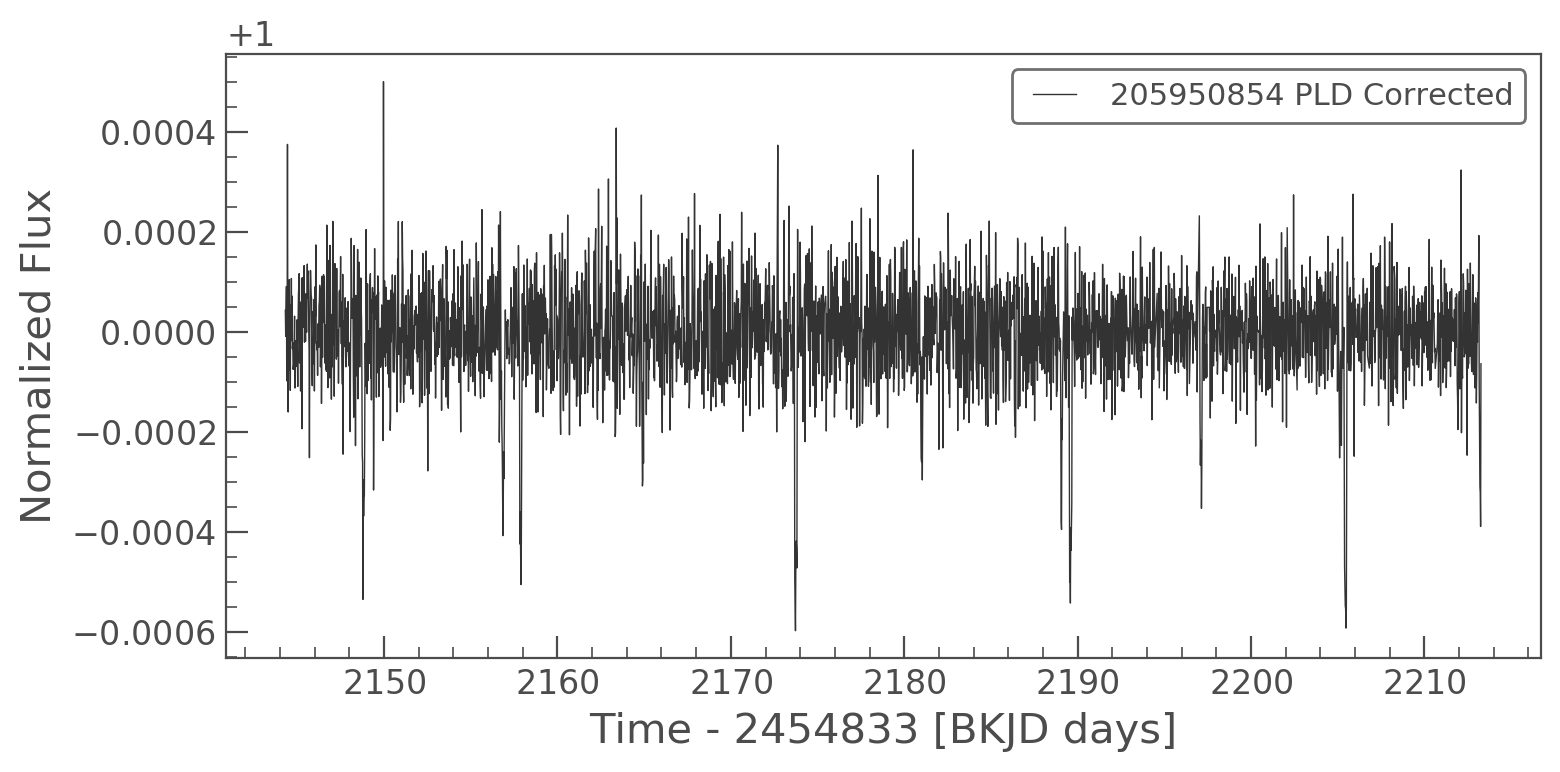

In [42]:
clc.plot()

In [ ]:
params = threemultis.utils.get_params('K2-168')
threemultis.utils.planet_plot(clc, 'K2-168', nbin=5);

In [11]:
trace, mask = threemultis.fit.fit_planets(clc, period_value=list(params['Period']),
                                            t0_value=list(params['T0']), depth_value=list(params['Depth']),
                                            R_star=(params.loc[0, 'R_star'], params.loc[0, 'R_star_error']),
                                            M_star=(params.loc[0, 'M_star'], params.loc[0, 'M_star_error']),
                                            T_star=(params.loc[0, 'T_star'], params.loc[0, 'T_star_error']), ndraws=2000)

Sampling 4 chains: 100%|██████████| 208/208 [00:05<00:00, 34.89draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logr, b, t0, logP, t_star, r_star, m_star, u_star, mean]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:09<00:00, 61.99draws/s]
The number of effective samples is smaller than 25% for some parameters.


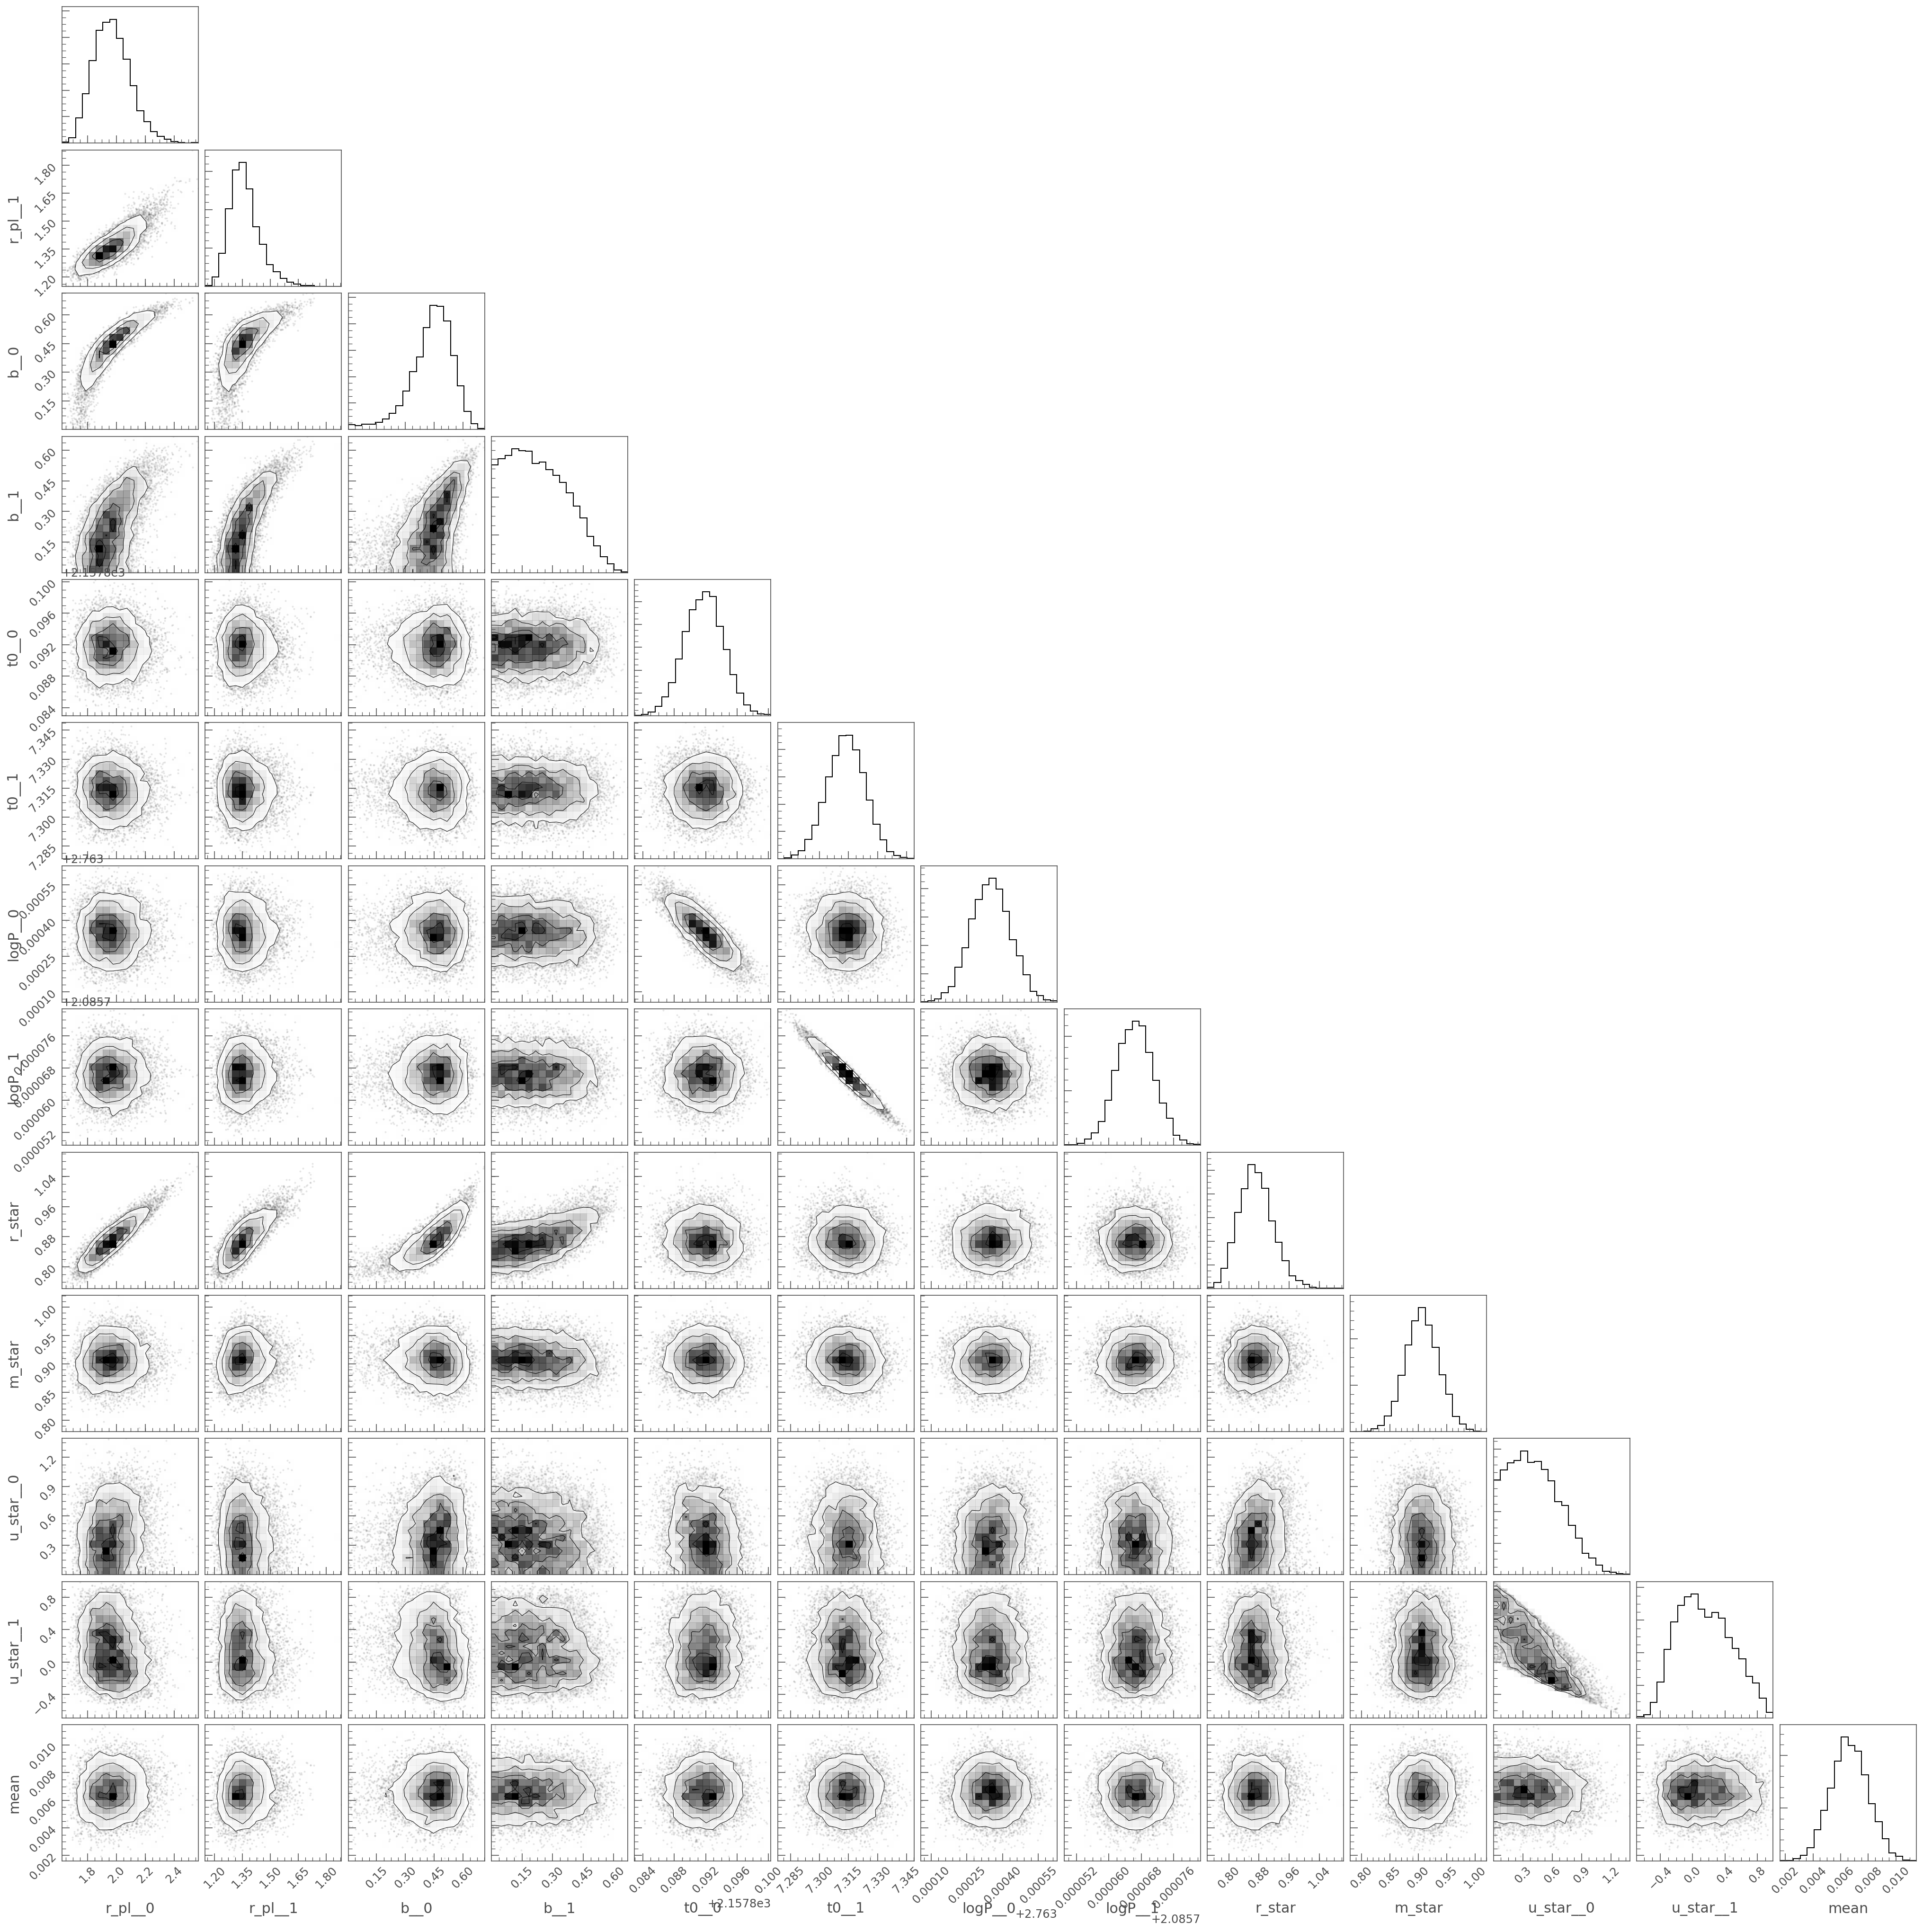

In [12]:
import pymc3 as pm
import corner
import astropy.units as u
varnames = varnames=["r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl__0"] = (np.array(samples["r_pl__0"]) * u.R_sun).to(u.R_earth).value
samples["r_pl__1"] = (np.array(samples["r_pl__1"]) * u.R_sun).to(u.R_earth).value


corner.corner(samples);

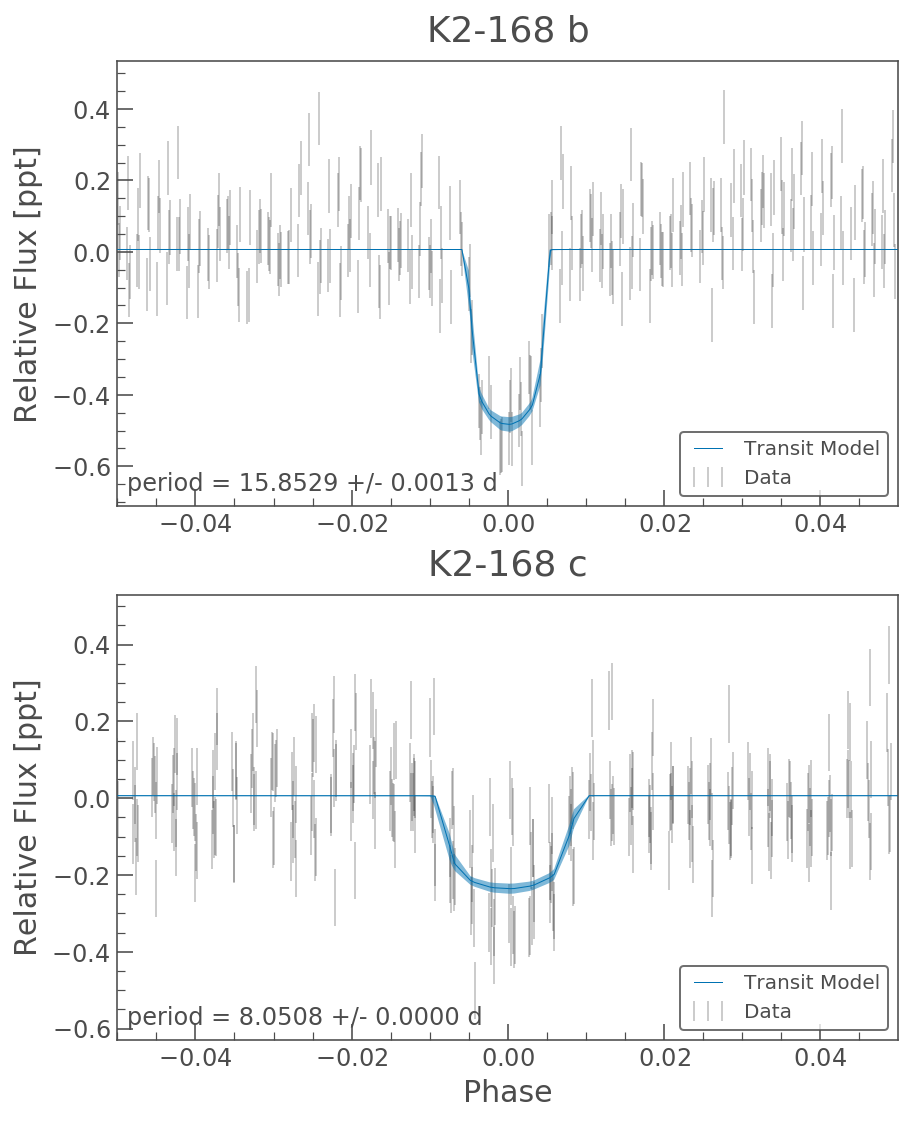

In [13]:
fig = threemultis.utils.plot_folded_transits(clc, trace, mask, 'K2-168');
fig.savefig('figures/K2-168.png', dpi=150, bbox_inches='tight')